# Speckle Size Analysis

In [29]:
import speckle
from speckle.inference.read_in_data import read_in_data
from speckle.inference.correlation_heatmap import get_correlation,dump_heatmap,display_correlation_heatmaps,mask_heatmap,plot_radius_distribution
from speckle.inference.calculating_tau import objective, avg_correlation_single_px, plot_correlation_vs_lagtime,fit_exponential_decay, reconstruct,avg_correlation,calculate_correlation_pixel
from speckle.inference.dedrift import dedrift_videos

In [30]:
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import numpy as np
from scipy.optimize import curve_fit
import math
from operator import itemgetter

In [31]:
def spatial_correlation(example_img, sp_shape,ROI):
    y_length=example_img.shape[0]
    x_length=example_img.shape[1]
    num_pixels=y_length*x_length
    spcorrelation_map = np.zeros((sp_shape,sp_shape))
    for dy in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
        for dx in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
            sum_numerator=0
            sum_denum_1=0
            sum_denum_2=0
            count=0
            for y in range(ROI[0],ROI[0]+ROI[2],1):
                for x in range(ROI[1],ROI[1]+ROI[3],1):
                    sum_numerator+=int(example_img[y][x])*int(example_img[y+dy][x+dx])
                    sum_denum_1+=int(example_img[y][x])
                    sum_denum_2+=int(example_img[y+dy][x+dx])
                    count+=1
            numerator=sum_numerator/count
            denum_1=sum_denum_1/count
            denum_2=sum_denum_2/count
            spcorrelation_map[dy+math.floor(sp_shape/2)][dx+math.floor(sp_shape/2)]=copy.deepcopy(numerator/(denum_1*denum_2)-1)
    normalization=spcorrelation_map[math.floor(sp_shape/2)][math.floor(sp_shape/2)]
    spcorrelation_map=spcorrelation_map/normalization
    sns.heatmap(spcorrelation_map)
    return spcorrelation_map

In [32]:
def plot_spmap(spcorrelation_map):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.')
    plt.legend(['Correlation vs delta r'], fontsize=18)
    plt.xlabel("delta r [pixels]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.show

In [33]:
def plot_spmap_x_direction(spcorrelation_map):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=np.array(spcorrelation_map)[int(spcorrelation_map.shape[0]/2)][:]
    
    plt.plot(radius_squared,spcorrelation_map_x,'.')
    #plt.xlim(0,10)
    plt.legend(['Correlation vs delta r'], fontsize=18)
    plt.xlabel("delta r [pixels]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.show

In [34]:
def calculate_speckle_size(spcorrelation_map,startidx,endidx,plotBoolean=True):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    radius_squared=radius_flatten*radius_flatten
    log_correlation=np.log(abs(spcorrelation_map_flatten))
    combined_list=[]
    combined_list.append(radius_squared)
    combined_list.append(log_correlation)
    combined_list=np.array(combined_list)
    combined_list_sorted=np.array(sorted(combined_list.transpose(),key=lambda lst:lst[1],reverse=True)).transpose()
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        print("speckle size is:",np.sqrt(-1/a))
        print('y = %.5f * x' % (a))
        # plot input vs output
        plt.scatter(x, y)
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 1)
        # calculate the output for the range
        y_line = objective(x_line, a)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()
        return np.sqrt(-1/a),a
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        return np.sqrt(-1/a)

def objective(x, a):
	return a * x

In [35]:
def calculate_speckle_size_x_direction(spcorrelation_map,startidx,endidx,plotBoolean=True):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=spcorrelation_map[int(spcorrelation_map.shape[0]/2)][:]
    log_correlation=np.log(abs(spcorrelation_map_x))
    combined_list=[]
    combined_list.append(radius_squared)
    combined_list.append(log_correlation)
    combined_list=np.array(combined_list)
    combined_list_sorted=np.array(sorted(combined_list.transpose(),key=lambda lst:lst[1],reverse=True)).transpose()
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        print("speckle size is:",np.sqrt(-1/a))
        print('y = %.5f * x' % (a))
        # plot input vs output
        plt.scatter(x, y)
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 1)
        # calculate the output for the range
        y_line = objective(x_line, a)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()
        return np.sqrt(-1/a),a
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        return np.sqrt(-1/a)

def objective(x, a):
	return a * x

In [36]:
def reconstruct_curve(spcorrelation_map,a):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.concatenate(radius).flat
    spcorrelation_map_flatten=np.concatenate(spcorrelation_map).flat
    y=np.zeros(len(radius_flatten))
    for i in range(0, len(radius_flatten),1):
        y[i]=(math.exp(a*radius_flatten[i]))
    plt.figure(figsize=(8,5))
    plt.plot(radius_flatten,y,'*',label="fit line")
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.',label="data")
    plt.legend(['Correlation vs Delta r'], fontsize=18)
    plt.xlabel("Delta r [pixel]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.legend(fontsize=18)

In [37]:
def reconstruct_curve_x_direction(spcorrelation_map,a):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=np.array(spcorrelation_map)[int(spcorrelation_map.shape[0]/2)][:]
    
    y=np.zeros(len(radius_squared))
    for i in range(0, len(radius_squared),1):
        y[i]=(math.exp(a*radius_squared[i]))
    plt.figure(figsize=(8,5))
    plt.plot(radius_squared,y,'*',label="fit line")
    plt.plot(radius_squared,spcorrelation_map_x,'.',label="data")
    plt.legend(['Correlation vs Delta r'], fontsize=18)
    plt.xlabel("Delta r [pixel]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.legend(fontsize=18)

# 24 hour video (256*256 size) - FUS

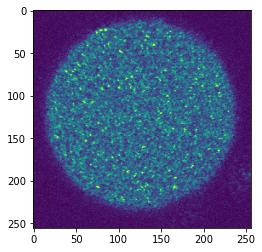

In [10]:
## Load in data
video_time_length=60 #s
video_frame_numbers=1129 #frames
imgname='1120f_FUS_24h_condensate_speckle_BF_1min_#2_equator'
foldername='/Volumes/wwyyrx/Wenyun/Speckle/FUS_24h_condensate_speckle_BF_1min_#2_equator/'
framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

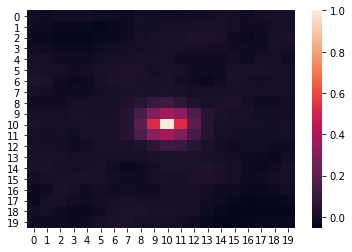

In [11]:
img_24h=img[20]
ROI=[80,70,100,110] #y,x,w,h
sp_shape=20
spmap_24h=spatial_correlation(img_24h,sp_shape,ROI)

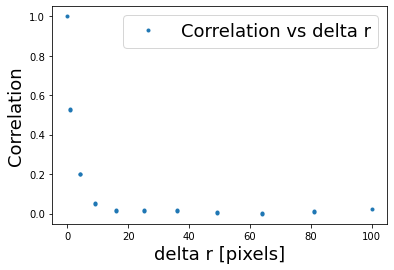

In [12]:
plot_spmap_x_direction(spmap_24h)

corresponds to speckle size $c_I(\delta_{r}) = exp(-\delta_{r}^2/\sigma^2)$

speckle size is: [1.5478303]
y = -0.41740 * x


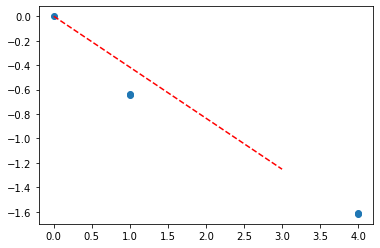

In [13]:
size_24h,a_24h =calculate_speckle_size_x_direction(spmap_24h,0,5)

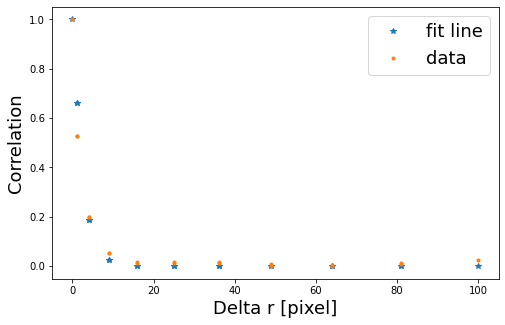

In [27]:
a_24h=-0.417
reconstruct_curve_x_direction(spmap_24h,a_24h)

In [47]:
scale=9.775
speckle_size_24h=np.sqrt(-1/a_24h)/scale
print('The size is :'+str(np.sqrt(-1/a_24h))+' pixel')
print('The size is :'+str(speckle_size_24h)+' um')

The size is :1.5485740327062774 pixel
The size is :0.15842189592903091 um


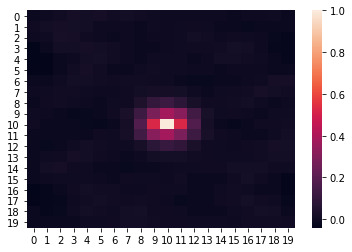

In [29]:
img_24h_900=img[900]
ROI=[80,70,100,110] #y,x,w,h
sp_shape=20
spmap_24h_900=spatial_correlation(img_24h_900,sp_shape,ROI)

In [ ]:
plot_spmap(spmap_24h_900)

In [ ]:
size_24h_900,a_24h_900=calculate_speckle_size(spmap_24h_900,0,6)

In [ ]:
a_24h_900=-0.95
reconstruct_curve(spmap_24h_900,a_24h_900)

In [ ]:
scale=9.775
speckle_size_24h_900=np.sqrt(-1/a_24h_900)/scale
print('The size is :'+str(np.sqrt(-1/a_24h_900))+' pixel')
print('The size is :'+str(speckle_size_24h_900)+' um')

# Fresh video(512*512) -FUS

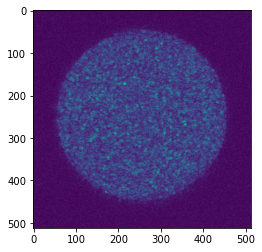

In [30]:
imgname='300f_405_1.0p_725gain_2min_1141frames_fresh'
foldername='/Users/wenyun/Desktop/research/Speckle project/Temp_data/405_1.0p_725gain_2min_1141frames_fresh/'
img=read_in_data(foldername,imgname)

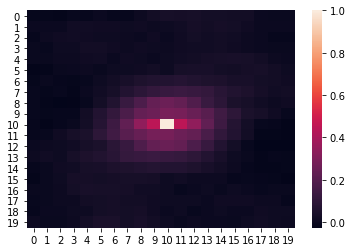

In [32]:
img_fresh_20=img[20]
ROI=[200,200,100,100] #y,x,w,h
sp_shape=20
spmap_fresh_20=spatial_correlation(img_fresh_20,sp_shape,ROI)

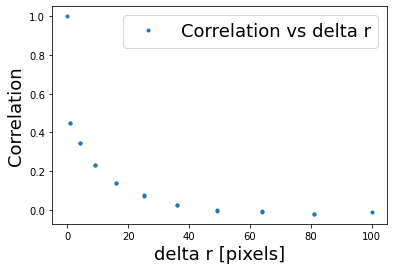

In [33]:
plot_spmap_x_direction(spmap_fresh_20)

speckle size is: [3.79666124]
y = -0.06937 * x


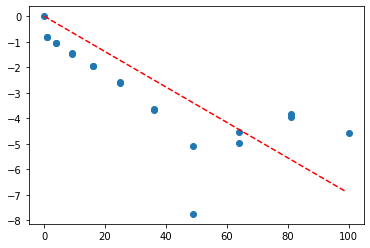

In [59]:
size_fresh,a_fresh=calculate_speckle_size_x_direction(spmap_fresh_20,0,20)

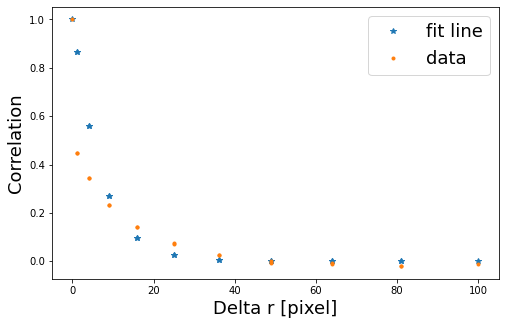

In [78]:
a_fresh=-0.145
reconstruct_curve_x_direction(spmap_fresh_20,a_fresh)

In [79]:
scale= 20.5155
speckle_size_fresh=np.sqrt(-1/a_fresh)/scale
print('The size is :'+str(np.sqrt(-1/a_fresh))+' pixel')
print('The size is :'+str(speckle_size_fresh)+' um')

The size is :2.6261286571944513 pixel
The size is :0.12800705111717733 um


bidirectional scan not aligned well

# UVed

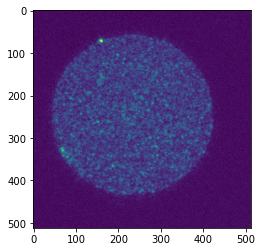

In [63]:
imgname='405_1.0p_725gain_2min_1141frmaes_fresh_after_UV'
foldername='/Users/wenyun/Desktop/research/Speckle project/Temp_data/405_1.0p_725gain_2min_1141frmaes_fresh_after_UV/'
img=read_in_data(foldername,imgname)

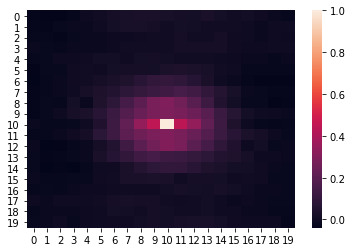

In [64]:
img_UV_20=img[20]
ROI=[200,200,100,100] #y,x,w,h
sp_shape=20
spmap_UV_20=spatial_correlation(img_UV_20,sp_shape,ROI)

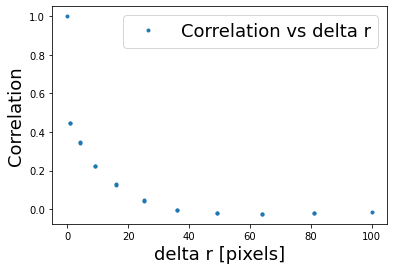

In [65]:
plot_spmap_x_direction(spmap_UV_20)

speckle size is: [2.20762985]
y = -0.20519 * x


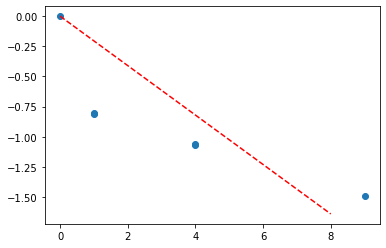

In [68]:
size_UVed,a_UVed=calculate_speckle_size_x_direction(spmap_UV_20,0,6)

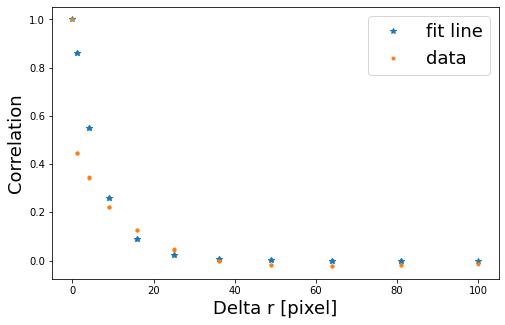

In [81]:
a_UVed=-0.15
reconstruct_curve_x_direction(spmap_UV_20,a_UVed)

In [82]:
scale= 20.5155
speckle_size_UVed=np.sqrt(-1/a_UVed)/scale
print('The size is :'+str(np.sqrt(-1/a_UVed))+' pixel')
print('The size is :'+str(speckle_size_UVed)+' um')

The size is :2.581988897471611 pixel
The size is :0.12585551887458807 um


# G3BP1

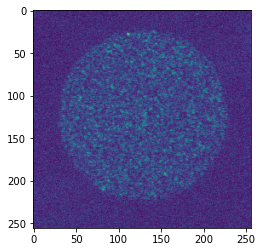

In [83]:
imgname='speckle_GFP_G3BP1_405nm_9power_2haged_equator_30s'
foldername='/Volumes/wwyyrx/Wenyun/Speckle/speckle_GFP_G3BP1_405nm_9power_2haged_equator_30s/'
img=read_in_data(foldername,imgname)

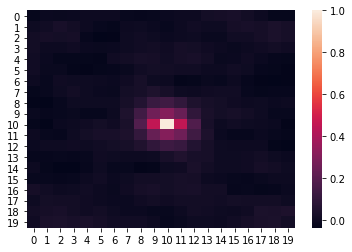

In [84]:
img_G3BP1_20=img[20]
ROI=[100,80,80,80] #y,x,w,h
sp_shape=20
spmap_G3BP1_20=spatial_correlation(img_G3BP1_20,sp_shape,ROI)

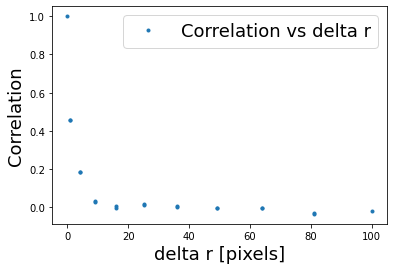

In [85]:
plot_spmap_x_direction(spmap_G3BP1_20)

speckle size is: [1.49902882]
y = -0.44502 * x


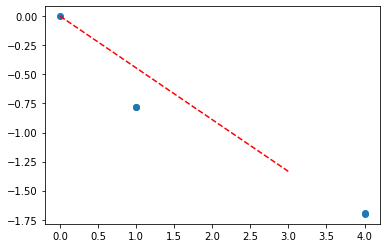

In [87]:
size_G3BP1,a_G3BP1=calculate_speckle_size_x_direction(spmap_G3BP1_20,0,5)

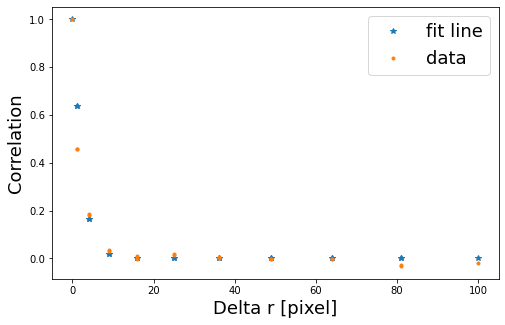

In [89]:
a_G3BP1=-0.45
reconstruct_curve_x_direction(spmap_G3BP1_20,a_G3BP1)

In [90]:
scale= 10.255
speckle_size_G3BP1=np.sqrt(-1/a_G3BP1)/scale
print('The size is :'+str(np.sqrt(-1/a_G3BP1))+' pixel')
print('The size is :'+str(speckle_size_G3BP1)+' um')

The size is :1.4907119849998598 pixel
The size is :0.14536440614333102 um


# PS beads (256*256)

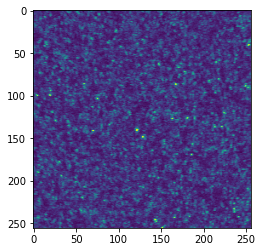

In [94]:
imgname='0p5wt_100nm_256px_1min_10to1_waterglycerol_1au'
foldername='/Volumes/WENYUN WANG/20220606/'
img=read_in_data(foldername,imgname)

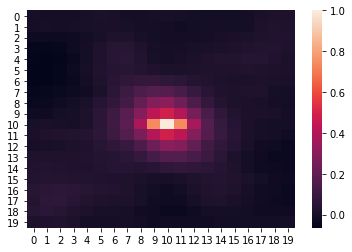

In [95]:
img_PS_20=img[20]
ROI=[100,80,80,80] #y,x,w,h
sp_shape=20
spmap_PS_20=spatial_correlation(img_PS_20,sp_shape,ROI)

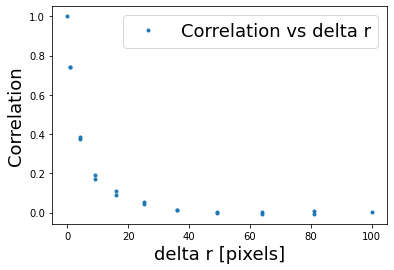

In [96]:
plot_spmap_x_direction(spmap_PS_20)

speckle size is: [3.49208209]
y = -0.08200 * x


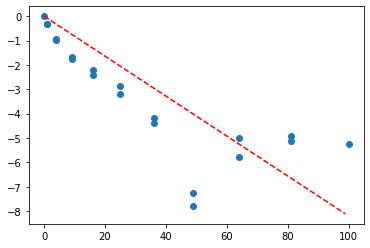

In [97]:
size_PS,a_PS=calculate_speckle_size_x_direction(spmap_PS_20,0,20)

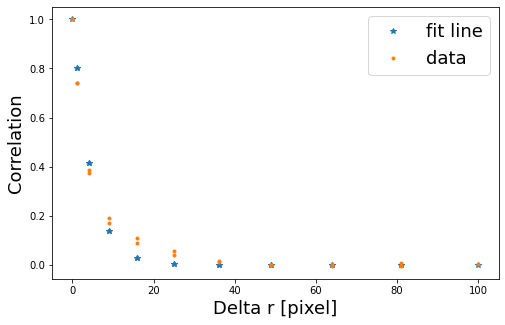

In [107]:
a_PS=-0.22
reconstruct_curve_x_direction(spmap_PS_20,a_PS)

In [105]:
scale= 10.8611
speckle_size_PS=np.sqrt(-1/a_PS)/scale
print('The size is :'+str(np.sqrt(-1/a_PS))+' pixel')
print('The size is :'+str(speckle_size_PS)+' um')

The size is :2.1320071635561044 pixel
The size is :0.19629753556786186 um


# PS beads (512*512 px)

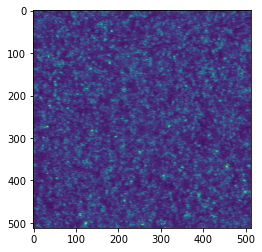

In [108]:
imgname='0p5wt_100nm_512px_1min_10to1_waterglycerol_1au'
foldername='/Volumes/WENYUN WANG/20220606/'
img=read_in_data(foldername,imgname)

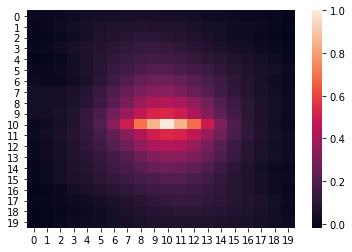

In [109]:
img_PS_512px=img[300]
ROI=[50,80,120,120] #y,x,w,h
sp_shape=20
spmap_PS_512px=spatial_correlation(img_PS_512px,sp_shape,ROI)

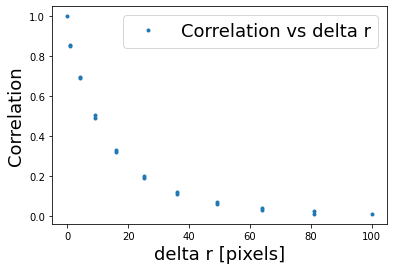

In [110]:
plot_spmap_x_direction(spmap_PS_512px)

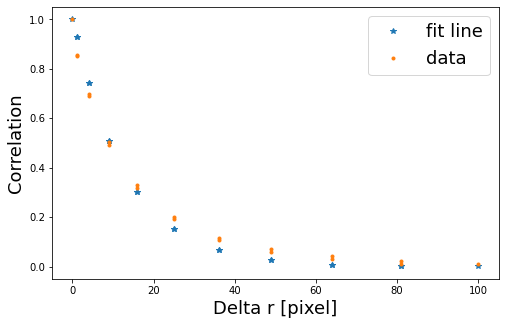

In [127]:
a_PS_512px=-0.075
reconstruct_curve_x_direction(spmap_PS_512px,a_PS_512px)

In [128]:
scale= 21.7233
speckle_size_PS_512px=np.sqrt(-1/a_PS_512px)/scale
print('The size is :'+str(np.sqrt(-1/a_PS_512px))+' pixel')
print('The size is :'+str(speckle_size_PS_512px)+' um')

The size is :3.6514837167011076 pixel
The size is :0.16809065458291825 um


# 1wt glycerol 100nm 20objective 0614 20x_magnification

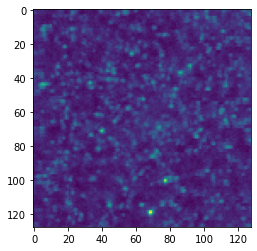

In [129]:
imgname='28p_1wt_100nm128px_2min_glycerol_1au_20x_26p5umhigh_488nm_20xobjective'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/28p_1wt_100nm128px_2min_glycerol_1au_20x_26p5umhigh_488nm_20xobjective/'
img=read_in_data(foldername,imgname)

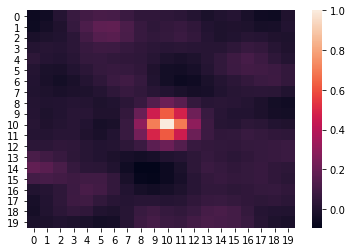

In [131]:
img_gly_100nm=img[300]
ROI=[40,40,40,40] #y,x,w,h
sp_shape=20
spmap_gly_100nm=spatial_correlation(img_gly_100nm,sp_shape,ROI)

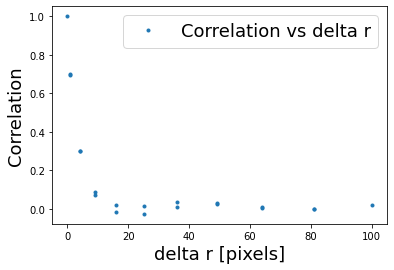

In [167]:
plot_spmap_x_direction(spmap_gly_100nm)

speckle size is: [1.8098437]
y = -0.30529 * x


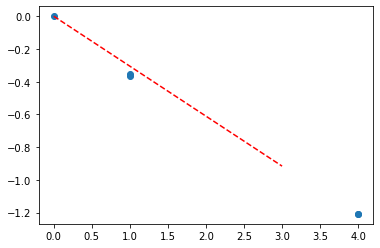

In [168]:
size_gly_100nm,a_gly_100nm=calculate_speckle_size_x_direction(spmap_gly_100nm,0,5)

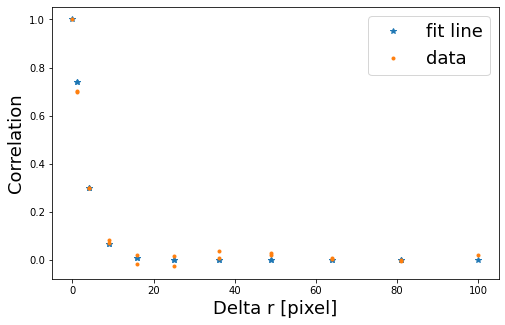

In [170]:
a_gly_100nm=-0.3
reconstruct_curve_x_direction(spmap_gly_100nm,a_gly_100nm)

In [171]:
scale= 6.0340
speckle_size_gly_100nm=np.sqrt(-1/a_gly_100nm)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm)+' um')

The size is :1.8257418583505538 pixel
The size is :0.3025757140123556 um


# 1wt glycerol 100nm 20objective 0614 30x_magnification

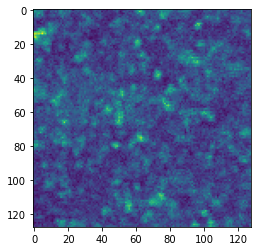

In [11]:
imgname='12p_1wt_100nm128px_2min_glycerol_1au_30x_58p5umhigh_488nm_20xobjective'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/12p_1wt_100nm128px_2min_glycerol_1au_30x_58p5umhigh_488nm_20xobjective/'
img=read_in_data(foldername,imgname)

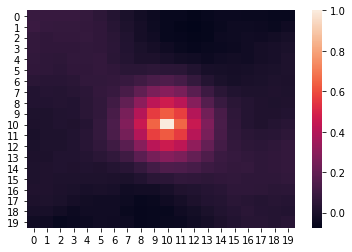

In [14]:
img_gly_100nm_30x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_30x=spatial_correlation(img_gly_100nm_30x,sp_shape,ROI)

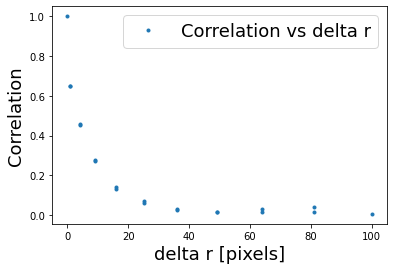

In [15]:
plot_spmap_x_direction(spmap_gly_100nm_30x)

speckle size is: [2.1824644]
y = -0.20995 * x


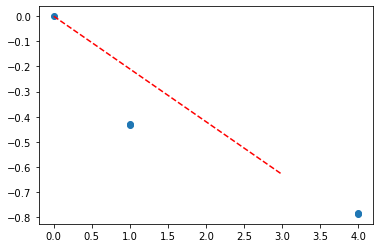

In [17]:
size_gly_100nm_30x,a_gly_100nm_30x=calculate_speckle_size_x_direction(spmap_gly_100nm_30x,0,5)

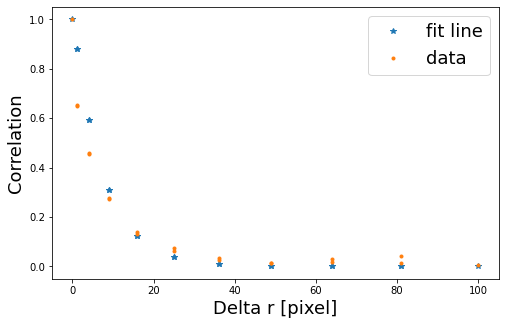

In [22]:
a_gly_100nm_30x=-0.13
reconstruct_curve_x_direction(spmap_gly_100nm_30x,a_gly_100nm_30x)

In [24]:
scale= 9.0509
speckle_size_gly_100nm_30x=np.sqrt(-1/a_gly_100nm_30x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_30x))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_30x)+' um')

The size is :2.7735009811261455 pixel
The size is :0.30643372273764435 um


# 40p_1wt_50nm128px_2min_glycerol_1au_20x_7umhigh_488nm (40x water obj. 1.2NA)

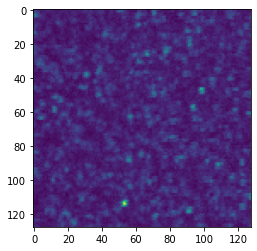

In [41]:
imgname='40p_1wt_50nm128px_2min_glycerol_1au_20x_7umhigh_405nm'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/40p_1wt_50nm128px_2min_glycerol_1au_20x_7umhigh_405nm/'
img=read_in_data(foldername,imgname)

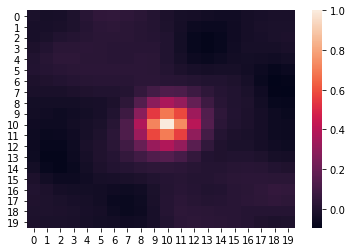

In [42]:
img_gly_50nm_40xobj=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_50nm_40xobj=spatial_correlation(img_gly_50nm_40xobj,sp_shape,ROI)

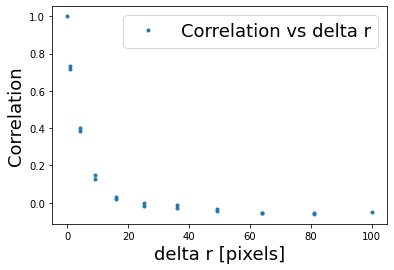

In [43]:
plot_spmap_x_direction(spmap_gly_50nm_40xobj)

speckle size is: [2.04714207]
y = -0.23862 * x


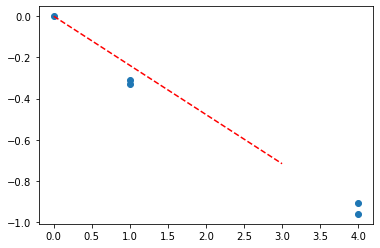

In [44]:
size_gly_50nm_40xobj,a_gly_50nm_40xobj=calculate_speckle_size_x_direction(spmap_gly_50nm_40xobj,0,5)

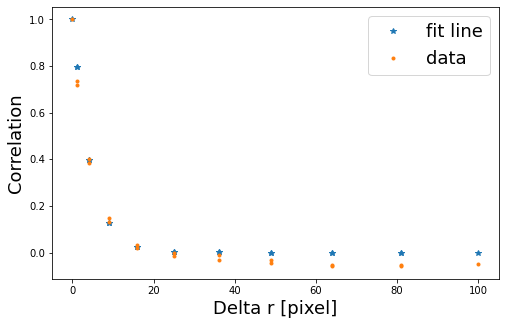

In [53]:
a_gly_50nm_40xobj=-0.23
reconstruct_curve_x_direction(spmap_gly_50nm_40xobj,a_gly_50nm_40xobj)

In [54]:
scale= 12.0679
speckle_size_gly_50nm_40xobj=np.sqrt(-1/a_gly_50nm_40xobj)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_50nm_40xobj))+' pixel')
print('The size is :'+str(speckle_size_gly_50nm_40xobj)+' um')

The size is :2.0851441405707476 pixel
The size is :0.1727843403219075 um


# 60p_405nm_2min_1wt_50nm_20xobj_30xmagn_111p1umhigh

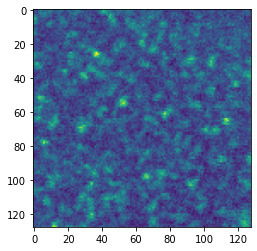

In [38]:
imgname='60p_405nm_2min_1wt_50nm_20xobj_30xmagn_111p1umhigh'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/60p_405nm_2min_1wt_50nm_20xobj_30xmagn_111p1umhigh/'
img=read_in_data(foldername,imgname)

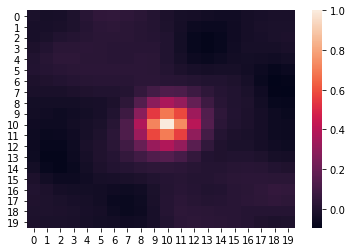

In [70]:
img_gly_50nm_20xobj_30x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_50nm_20xobj_30x=spatial_correlation(img_gly_50nm_20xobj_30x,sp_shape,ROI)

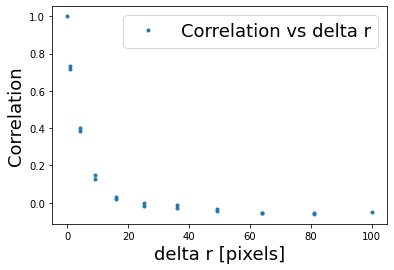

In [71]:
plot_spmap_x_direction(spmap_gly_50nm_20xobj_30x)

speckle size is: [2.04714207]
y = -0.23862 * x


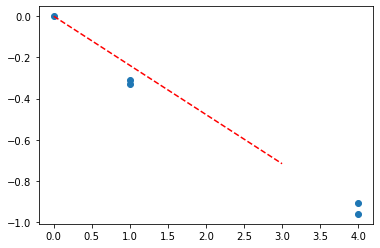

In [72]:
size_gly_50nm_20xobj_30x,a_gly_50nm_20xobj_30x=calculate_speckle_size_x_direction(spmap_gly_50nm_20xobj_30x,0,5)

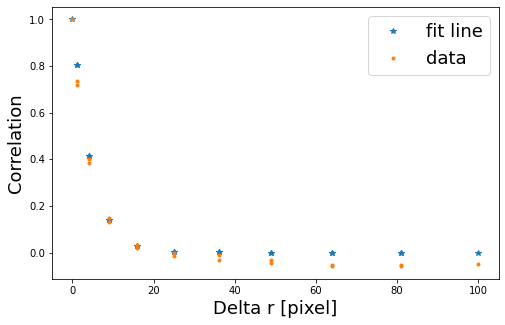

In [76]:
a_gly_50nm_20xobj_30x=-0.22
reconstruct_curve_x_direction(spmap_gly_50nm_20xobj_30x,a_gly_50nm_20xobj_30x)

In [74]:
scale= 9.0509
speckle_size_gly_50nm_20xobj_30x=np.sqrt(-1/a_gly_50nm_20xobj_30x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_50nm_20xobj_30x))+' pixel')
print('The size is :'+str(speckle_size_gly_50nm_20xobj_30x)+' um')

The size is :2.041241452319315 pixel
The size is :0.22552911338312379 um


# 40p_405nm_2min_1wt_100nm_10xobj_20xmagn_155p91umhigh

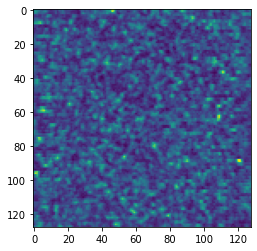

In [10]:
imgname='40p_405nm_2min_1wt_100nm_10xobj_20xmagn_155p91umhigh'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/40p_405nm_2min_1wt_100nm_10xobj_20xmagn_155p91umhigh/'
img=read_in_data(foldername,imgname)

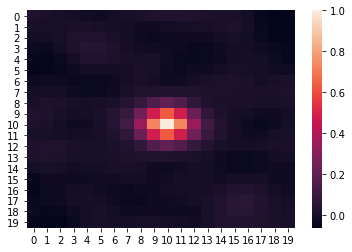

In [14]:
img_gly_100nm_10xobj_20x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_10xobj_20x=spatial_correlation(img_gly_100nm_10xobj_20x,sp_shape,ROI)

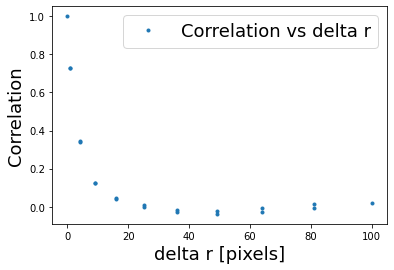

In [15]:
plot_spmap_x_direction(spmap_gly_100nm_10xobj_20x)

speckle size is: [1.92207512]
y = -0.27068 * x


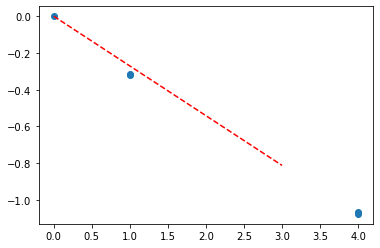

In [16]:
size_gly_100nm_10xobj_20x,a_gly_100nm_10xobj_20x=calculate_speckle_size_x_direction(spmap_gly_100nm_10xobj_20x,0,5)

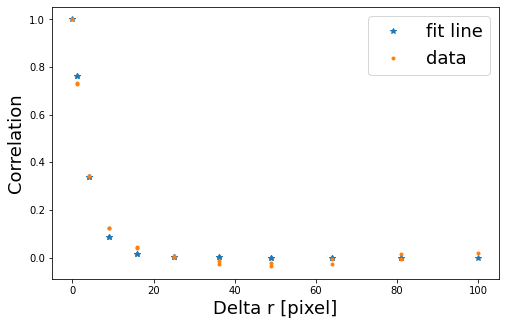

In [18]:
a_gly_100nm_10xobj_20x=-0.2708
reconstruct_curve_x_direction(spmap_gly_100nm_10xobj_20x,a_gly_100nm_10xobj_20x)

In [20]:
scale= 3.0170
speckle_size_gly_100nm_10xobj_20x=np.sqrt(-1/a_gly_100nm_10xobj_20x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_10xobj_20x))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_10xobj_20x)+' um')

The size is :1.9216561050602199 pixel
The size is :0.6369426930925489 um


# 40p_405nm_2min_1wt_100nm_10xobj_40xmagn_155p91umhigh

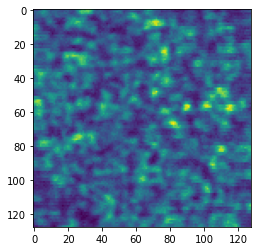

In [22]:
imgname='40p_405nm_2min_1wt_100nm_10xobj_40xmagn_155p91umhigh'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/40p_405nm_2min_1wt_100nm_10xobj_40xmagn_155p91umhigh/'
img=read_in_data(foldername,imgname)

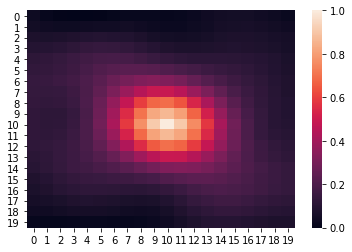

In [23]:
img_gly_100nm_10xobj_40x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_10xobj_40x=spatial_correlation(img_gly_100nm_10xobj_40x,sp_shape,ROI)

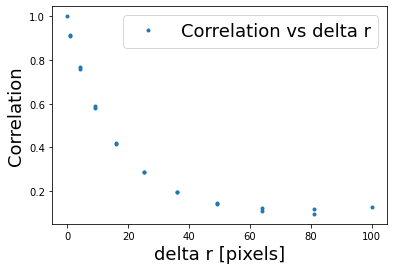

In [24]:
plot_spmap_x_direction(spmap_gly_100nm_10xobj_40x)

speckle size is: [4.32901062]
y = -0.05336 * x


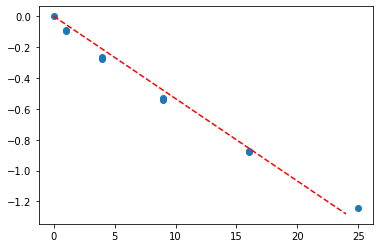

In [27]:
size_gly_100nm_10xobj_40x,a_gly_100nm_10xobj_40x=calculate_speckle_size_x_direction(spmap_gly_100nm_10xobj_40x,0,10)

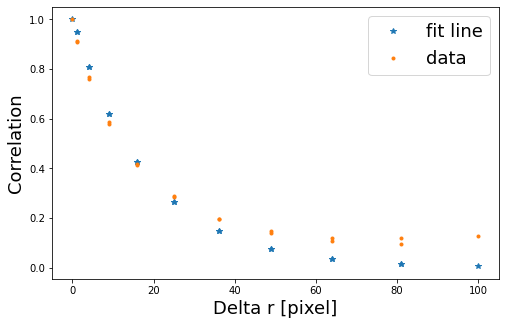

In [39]:
a_gly_100nm_10xobj_40x=-0.05336
reconstruct_curve_x_direction(spmap_gly_100nm_10xobj_40x,a_gly_100nm_10xobj_40x)

In [40]:
scale= 6.0340
speckle_size_gly_100nm_10xobj_40x=np.sqrt(-1/a_gly_100nm_10xobj_40x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_10xobj_40x))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_10xobj_40x)+' um')

The size is :4.329044892947799 pixel
The size is :0.7174419776181304 um


# 28p_1wt_100nm128px_2min_glycerol_1au_20x_9umhigh_405nm

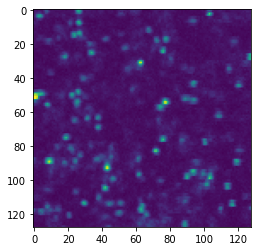

In [41]:
imgname='28p_1wt_100nm128px_2min_glycerol_1au_20x_9umhigh_405nm'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/28p_1wt_100nm128px_2min_glycerol_1au_20x_9umhigh_405nm/'
img=read_in_data(foldername,imgname)

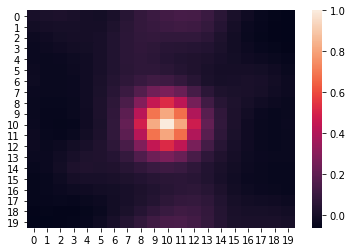

In [42]:
img_gly_100nm_40xobj_20x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_40xobj_20x=spatial_correlation(img_gly_100nm_40xobj_20x,sp_shape,ROI)

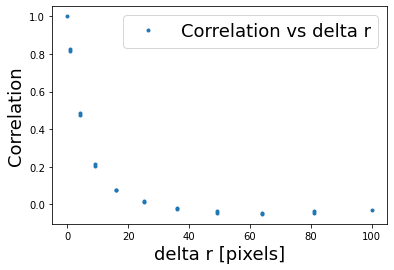

In [43]:
plot_spmap_x_direction(spmap_gly_100nm_40xobj_20x)

speckle size is: [2.33168583]
y = -0.18393 * x


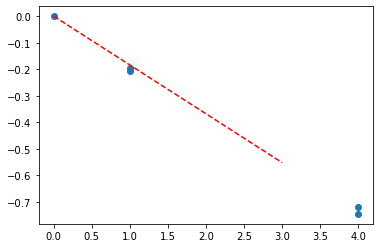

In [45]:
size_gly_100nm_40xobj_20x,a_gly_100nm_40xobj_20x=calculate_speckle_size_x_direction(spmap_gly_100nm_40xobj_20x,0,5)

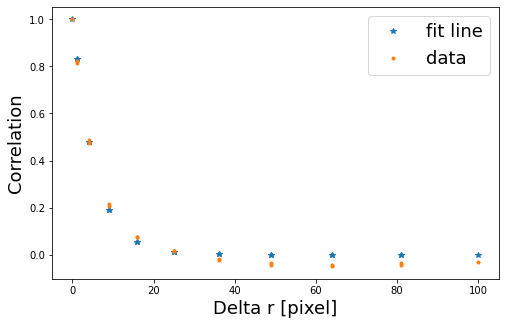

In [46]:
a_gly_100nm_40xobj_20x=-0.18393
reconstruct_curve_x_direction(spmap_gly_100nm_40xobj_20x,a_gly_100nm_40xobj_20x)

In [47]:
scale= 12.0679
speckle_size_gly_100nm_40xobj_20x=np.sqrt(-1/a_gly_100nm_40xobj_20x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_40xobj_20x))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_40xobj_20x)+' um')

The size is :2.3317055937477935 pixel
The size is :0.1932155216523002 um


# 4p5_1wt_100nm128px_1min_glycerol_1au_20x_51p4umhigh_405nm_20xobjective

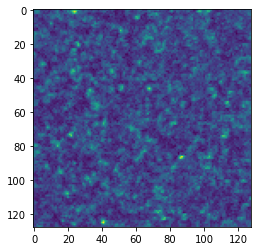

In [11]:
imgname='4p5_1wt_100nm128px_1min_glycerol_1au_20x_51p4umhigh_405nm_20xobjective'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/4p5_1wt_100nm128px_1min_glycerol_1au_20x_51p4umhigh_405nm_20xobjective/'
img=read_in_data(foldername,imgname)

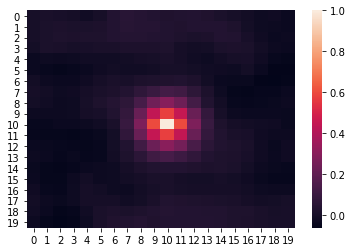

In [12]:
img_gly_100nm_20xobj_20x_0615=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_20xobj_20x_0615=spatial_correlation(img_gly_100nm_20xobj_20x_0615,sp_shape,ROI)

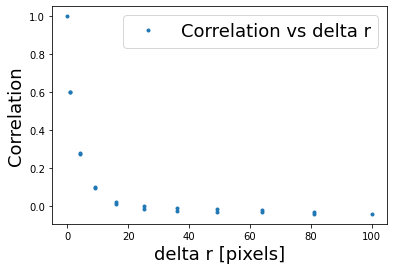

In [13]:
plot_spmap_x_direction(spmap_gly_100nm_20xobj_20x_0615)

speckle size is: [1.73621305]
y = -0.33174 * x


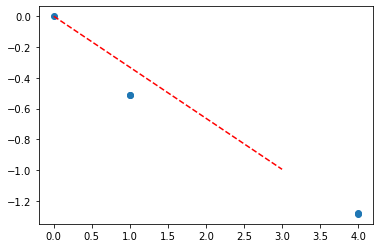

In [14]:
size_gly_100nm_20xobj_20x_0615,a_gly_100nm_20xobj_20x_0615=calculate_speckle_size_x_direction(spmap_gly_100nm_20xobj_20x_0615,0,5)

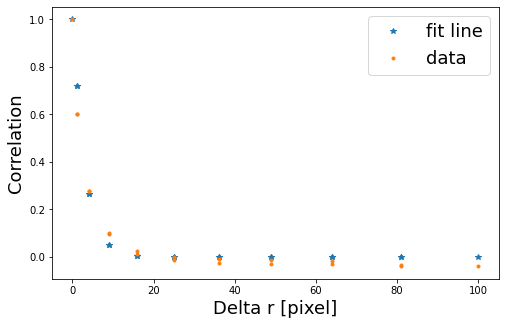

In [15]:
a_gly_100nm_20xobj_20x_0615=-0.33174
reconstruct_curve_x_direction(spmap_gly_100nm_20xobj_20x_0615,a_gly_100nm_20xobj_20x_0615)

In [16]:
scale= 6.0340
speckle_size_gly_100nm_20xobj_20x_0615=np.sqrt(-1/a_gly_100nm_20xobj_20x_0615)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_20xobj_20x_0615))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_20xobj_20x_0615)+' um')

The size is :1.736205308832952 pixel
The size is :0.2877370415699291 um


# Leica demo

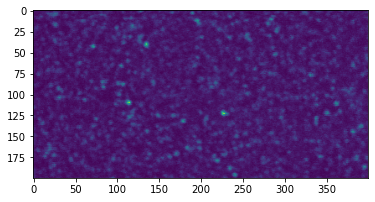

In [17]:
imgname='100nm_demo'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/leica_demo/'
img=read_in_data(foldername,imgname)

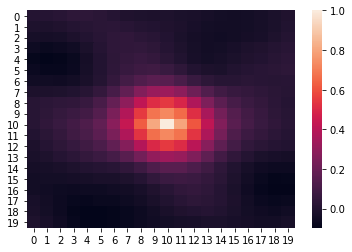

In [18]:
img_gly_100nm_leica=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_leica=spatial_correlation(img_gly_100nm_leica,sp_shape,ROI)

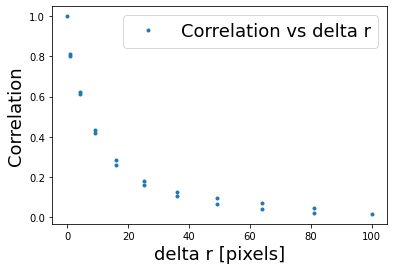

In [19]:
plot_spmap_x_direction(spmap_gly_100nm_leica)

speckle size is: [3.57489938]
y = -0.07825 * x


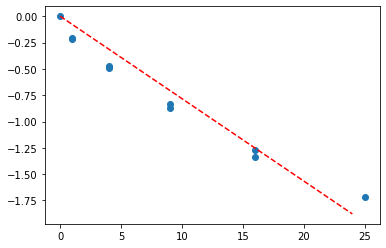

In [24]:
size_gly_100nm_leica,a_gly_100nm_leica=calculate_speckle_size_x_direction(spmap_gly_100nm_leica,0,10)

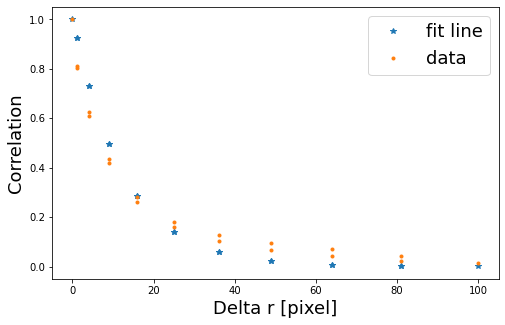

In [26]:
a_gly_100nm_leica=-0.07825
reconstruct_curve_x_direction(spmap_gly_100nm_leica,a_gly_100nm_leica)

In [27]:
scale= 10.9832
speckle_size_gly_100nm_leica=np.sqrt(-1/a_gly_100nm_leica)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_leica))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_leica)+' um')

The size is :3.5748500270158123 pixel
The size is :0.32548346811637885 um


# 0712 data

In [386]:
def calculate_speckle_size_x_direction_try(spcorrelation_map,startidx,endidx,plotBoolean=True):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=spcorrelation_map[int(spcorrelation_map.shape[0]/2)][:]
    plateau=spcorrelation_map_x[-1]
    if plateau>0.05 or plateau<0:
        log_correlation=np.log(abs(spcorrelation_map_x-plateau))
    else:
        log_correlation=np.log(abs(spcorrelation_map_x))
    combined_list=[]
    combined_list.append(radius_squared)
    combined_list.append(log_correlation)
    combined_list=np.array(combined_list)
    combined_list_sorted=np.array(sorted(combined_list.transpose(),key=lambda lst:lst[1],reverse=True)).transpose()
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        popt, _ = curve_fit(objective_try, x, y)
        # summarize the parameter values
        a,b= popt
        print("speckle size is:",np.sqrt(-1/a))
        print('y = %.5f * x' % (a))
        # plot input vs output
        plt.scatter(x, y)
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 1)
        # calculate the output for the range
        y_line = objective_try(x_line, a,b)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()
        return np.sqrt(-1/a),a,b
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        popt, _ = curve_fit(objective_try, x, y)
        # summarize the parameter values
        a,b= popt
        return np.sqrt(-1/a)

def objective_try(x, a,b):
	return a * x+b

In [504]:
def reconstruct_curve_x_direction_try(spcorrelation_map,a,b,):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=np.array(spcorrelation_map)[int(spcorrelation_map.shape[0]/2)][:]
    plateau=spcorrelation_map_x[-1]
        
    y=np.zeros(len(radius_squared))
    for i in range(0, len(radius_squared),1):
        y[i]=(math.exp(a*radius_squared[i]))*math.exp(b)
    if plateau>0.05 or plateau<0:
        y=y+plateau
    plt.figure(figsize=(8,5))
    plt.plot(radius_squared,y,'*',label="fit line")
    plt.plot(radius_squared,spcorrelation_map_x,'.',label="data")
    plt.legend(['Correlation vs Delta r'], fontsize=18)
    plt.xlabel("Delta r [pixel]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.legend(fontsize=18)
    plt.tick_params(direction='in')

## 100 nm 0.05 wt% 10xobj 0.47A.U.

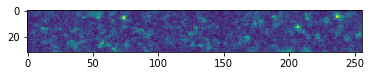

In [344]:
imgname='0p05percentwt_100nm_inglycerol_84umdepth_30s_0p47au_10xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)

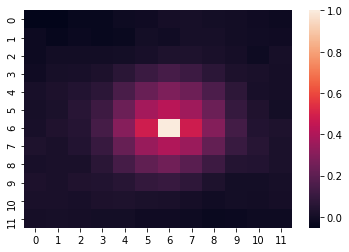

In [345]:
img=img[3]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

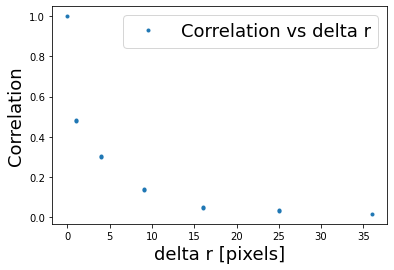

In [346]:
plot_spmap_x_direction(spmap)

speckle size is: 2.573837720029154
y = -0.15095 * x


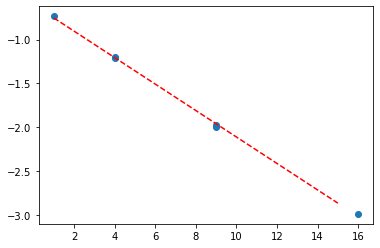

In [356]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,2,8)

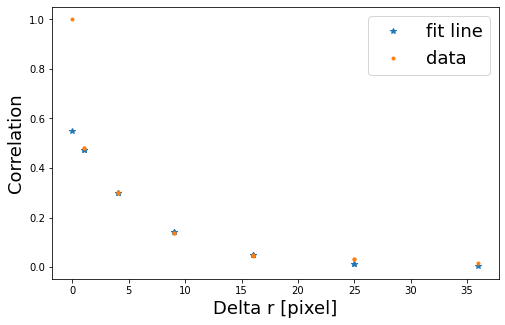

In [357]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [358]:
scale= 6.0340
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.573837720029154 pixel
The size is :0.4265558037834196 um


## 100 nm 0.05 wt% 10xobj 1A.U.

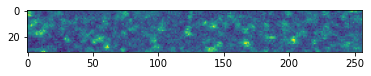

In [359]:
imgname='0p05percentwt_100nm_inglycerol_82umdepth_2min_1au_10x_obj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)

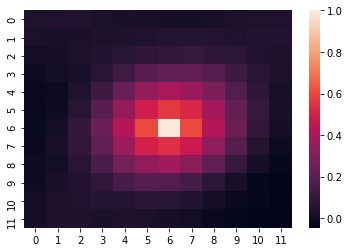

In [360]:
img=img[300]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

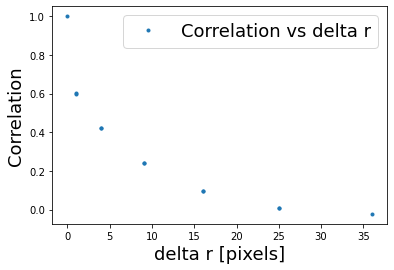

In [361]:
plot_spmap_x_direction(spmap)

speckle size is: 2.7301342540912925
y = -0.13416 * x


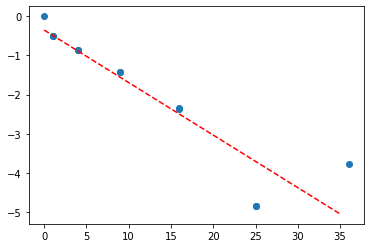

In [362]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,12)

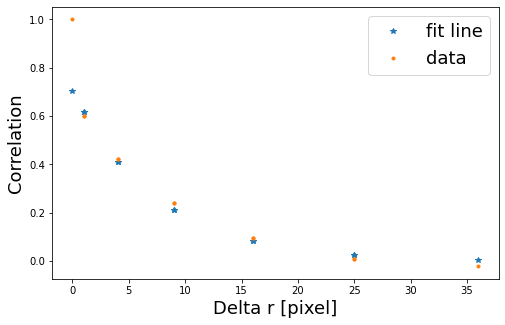

In [363]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [364]:
scale= 6.0340
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.7301342540912925 pixel
The size is :0.4524584444964025 um


## 100 nm 0.05 wt% 10xobj 2A.U.

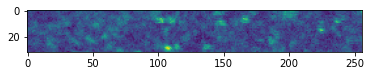

In [365]:
imgname='0p05percentwt_100nm_inglycerol_82umdepth_1min_2au_10xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

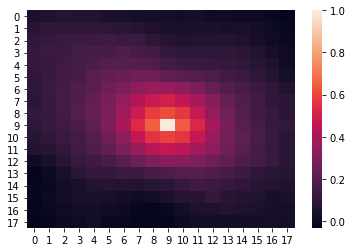

In [366]:
ROI=[7,10,16,230] #y,x,h,w
sp_shape=18
spmap=spatial_correlation(img,sp_shape,ROI)

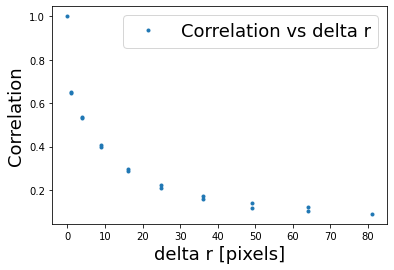

In [367]:
plot_spmap_x_direction(spmap)

speckle size is: 3.7684666574437276
y = -0.07042 * x


<ipython-input-343-b772314ba298>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


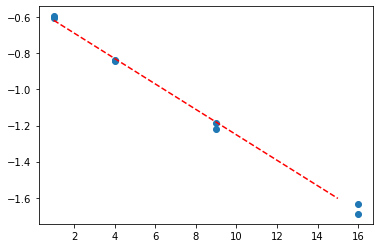

In [368]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,9)

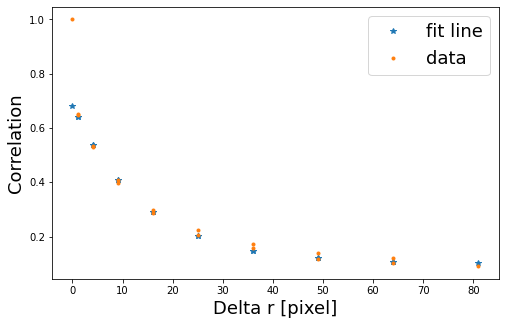

In [371]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [372]:
scale= 6.0340
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :3.7684666574437276 pixel
The size is :0.6245387234742671 um


## 100 nm 0.05% 20xobj 0.69 A.U.

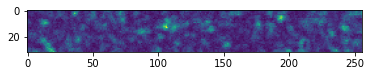

In [381]:
imgname='0p05percentwt_100nm_inglycerol_92umdepth_1min_0p69au_20xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

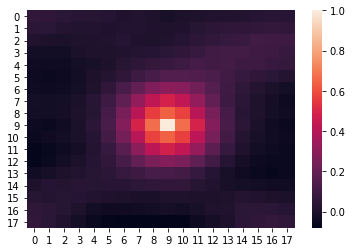

In [382]:
ROI=[7,10,16,230] #y,x,h,w
sp_shape=18
spmap=spatial_correlation(img,sp_shape,ROI)

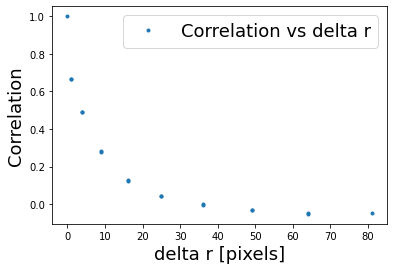

In [383]:
plot_spmap_x_direction(spmap)

speckle size is: 3.296093779268087
y = -0.09205 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


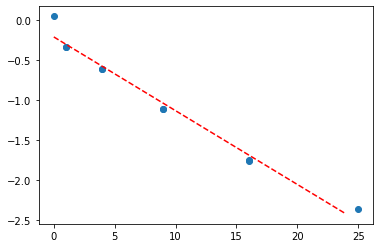

In [388]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,10)

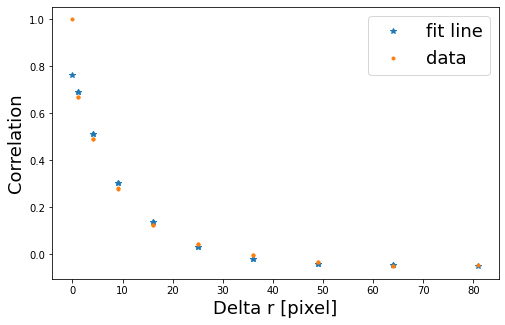

In [389]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [390]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :3.296093779268087 pixel
The size is :0.2731290265305552 um


## 100 nm 0.05 wt% 20xobj 1 A.U.

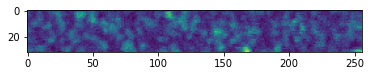

In [391]:
imgname='0p05percentwt_100nm_inglycerol_92umdepth_1min_1au_20xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

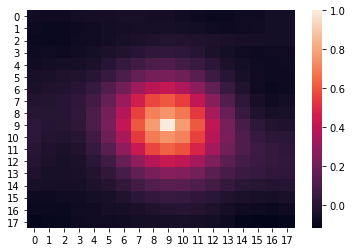

In [392]:
ROI=[7,10,16,230] #y,x,h,w
sp_shape=18
spmap=spatial_correlation(img,sp_shape,ROI)

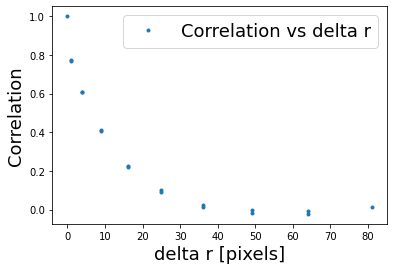

In [393]:
plot_spmap_x_direction(spmap)

speckle size is: 3.525777632943092
y = -0.08044 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


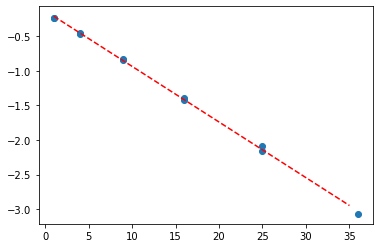

In [397]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,12)

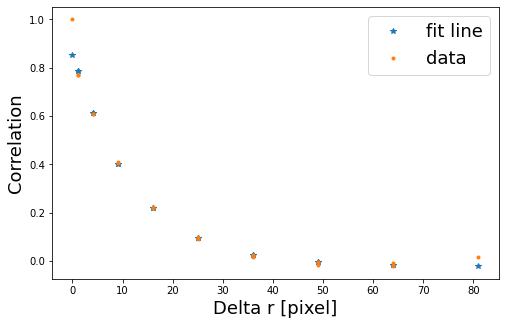

In [398]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [399]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :3.525777632943092 pixel
The size is :0.29216165471565825 um


## 100 nm 0.05 wt% 20xobj 1.8 A.U.

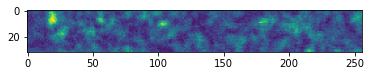

In [374]:
imgname='0p05percentwt_100nm_inglycerol_92umdepth_1min_1p8au_20xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

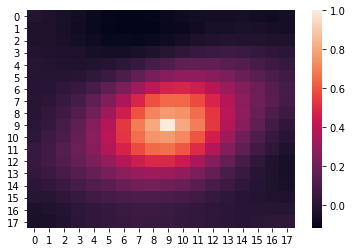

In [375]:
ROI=[7,10,16,230] #y,x,h,w
sp_shape=18
spmap=spatial_correlation(img,sp_shape,ROI)

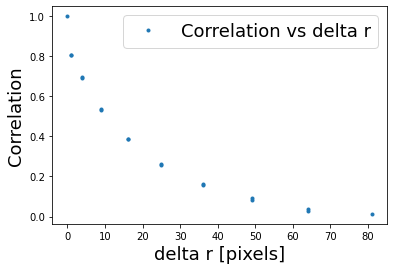

In [376]:
plot_spmap_x_direction(spmap)

speckle size is: 4.573622664715087
y = -0.04781 * x


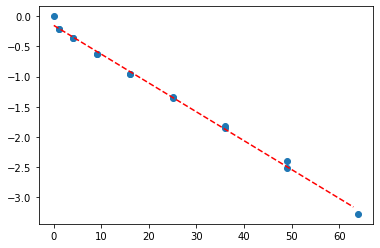

In [377]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,16)

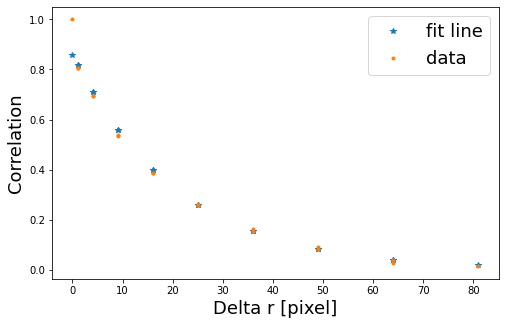

In [379]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [380]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :4.573622664715087 pixel
The size is :0.3789907659754462 um


## 100 nm 0.05 wt% 20xobj 2.95 A.U.

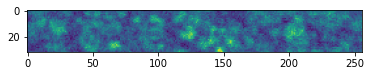

In [400]:
imgname='0p05percentwt_100nm_inglycerol_92umdepth_1min_2p95au_20xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

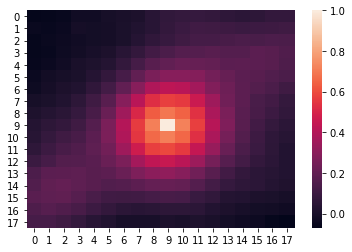

In [401]:
ROI=[7,10,16,230] #y,x,h,w
sp_shape=18
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 3.711485352858625
y = -0.07259 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


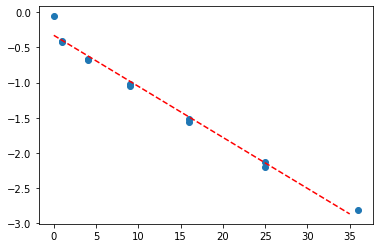

In [403]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,12)

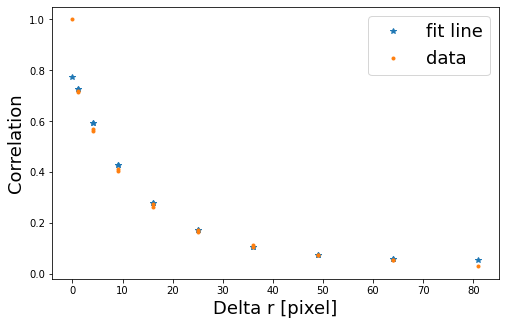

In [404]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [405]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :3.711485352858625 pixel
The size is :0.30755022438523894 um


## 100 nm 0.05 wt% 40xobj 1 A.U.

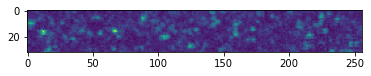

In [406]:
imgname='0p05percentwt_100nm_inglycerol_102umdepth_1min_1au_40xwobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

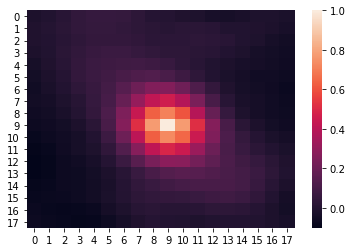

In [407]:
ROI=[7,10,16,230] #y,x,h,w
sp_shape=18
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 3.1180226606221395
y = -0.10286 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


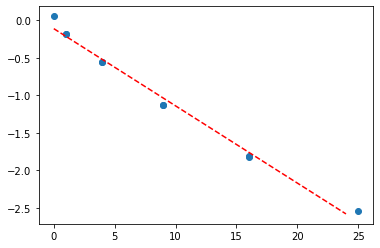

In [416]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,10)

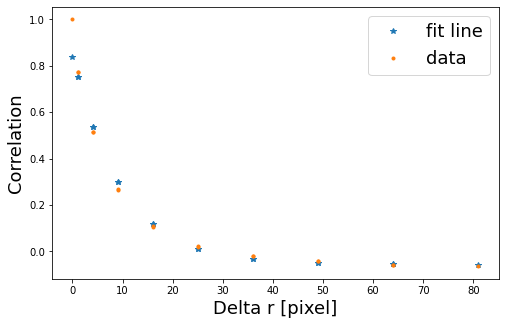

In [417]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [418]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :3.1180226606221395 pixel
The size is :0.2583732596907614 um


## 100 nm 0.05 wt% 40xobj 4.08 A.U.

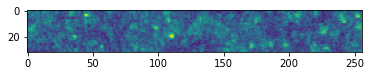

In [419]:
imgname='0p05percentwt_100nm_inglycerol_102umdepth_1min_4p08au_40xwobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

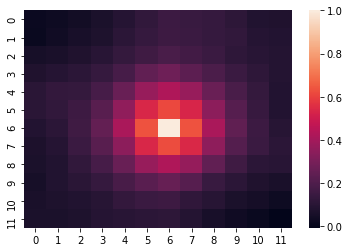

In [450]:
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 2.603528314247755
y = -0.14753 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


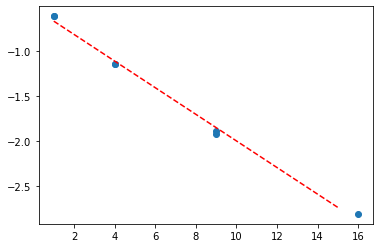

In [458]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,8)

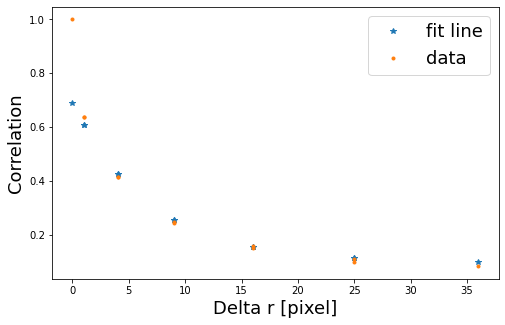

In [459]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [460]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.603528314247755 pixel
The size is :0.21573996422308397 um


## 100 nm 0.05 wt% 40xobj 6.77 A.U.

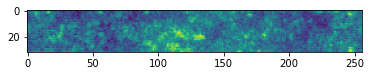

In [461]:
imgname='0p05percentwt_100nm_inglycerol_102umdepth_1min_6p77au_40xwobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

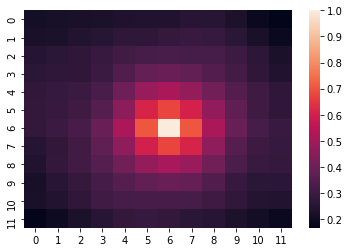

In [462]:
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 2.422875005516064
y = -0.17035 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


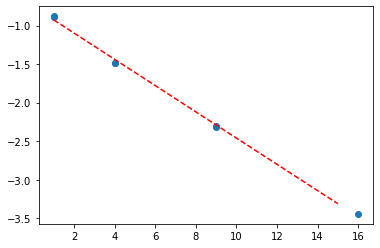

In [463]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,8)

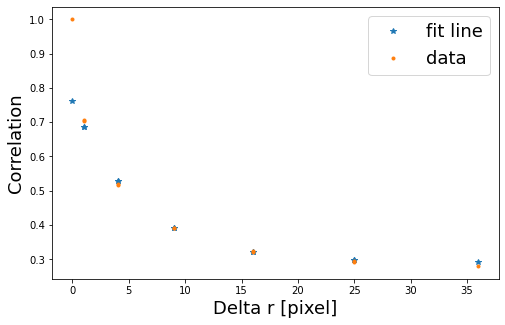

In [464]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [465]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.422875005516064 pixel
The size is :0.2007702255998197 um


## 100 nm 0.27 wt% 10xobj 0.26 A.U.

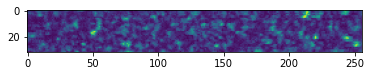

In [466]:
imgname='0p27percentwt_100nm_inglycerol_83umdepth_30s_0p26au_10xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

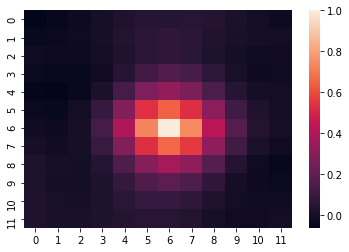

In [467]:
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 2.252403998999725
y = -0.19711 * x


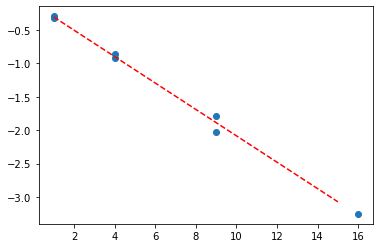

In [468]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,8)

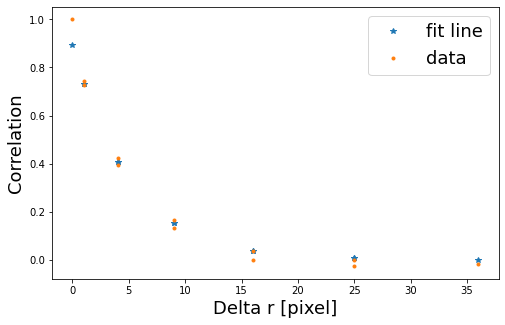

In [469]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [471]:
scale= 6.0340
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.252403998999725 pixel
The size is :0.37328538266485334 um


## 100 nm 0.27 wt% 10xobj 1 A.U.

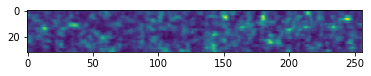

In [472]:
imgname='0p27percentwt_100nm_inglycerol_83umdepth_30s_1au_10xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

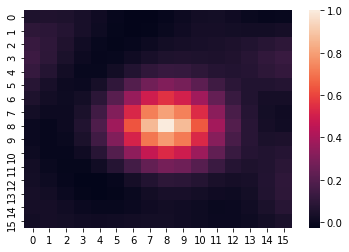

In [489]:
ROI=[7,10,17,230] #y,x,h,w
sp_shape=16
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 3.150944543901919
y = -0.10072 * x


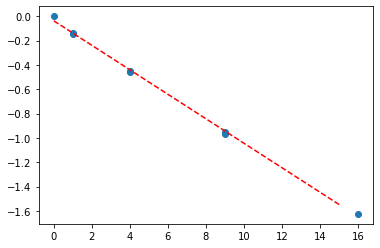

In [490]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,8)

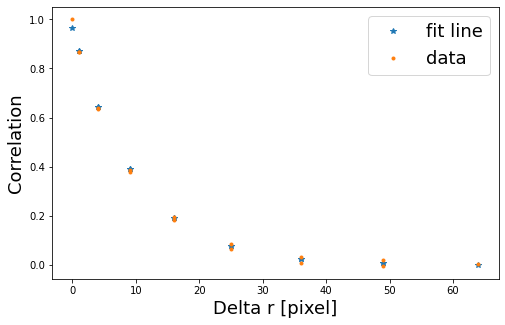

In [491]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [492]:
scale= 6.0340
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :3.150944543901919 pixel
The size is :0.5221983002820548 um


## 100 nm 0.27 wt% 20xobj 0.69 A.U.

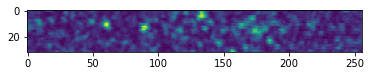

In [493]:
imgname='0p27percentwt_100nm_inglycerol_75umdepth_1min_0p69au_20xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

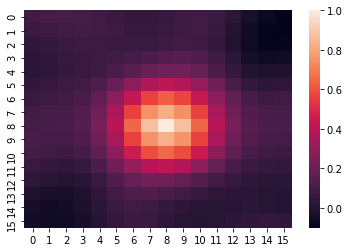

In [494]:
ROI=[7,10,17,230] #y,x,h,w
sp_shape=16
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 2.86238481532174
y = -0.12205 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


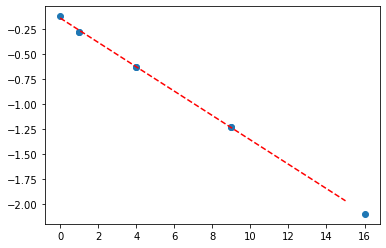

In [495]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,8)

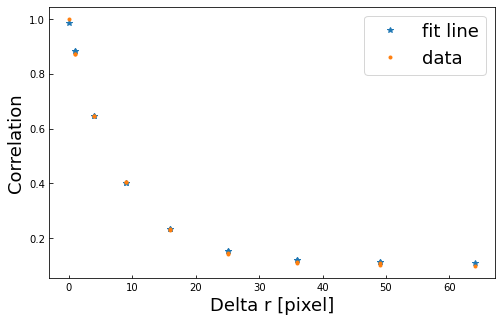

In [505]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [506]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.86238481532174 pixel
The size is :0.23718996804097978 um


## 100 nm 0.27 wt% 20xobj 1 A.U.

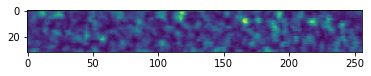

In [507]:
imgname='0p27percentwt_100nm_inglycerol_75umdepth_1min_1au_20xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

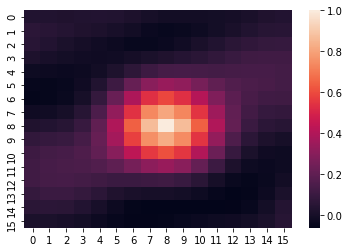

In [508]:
ROI=[7,10,17,230] #y,x,h,w
sp_shape=16
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 3.2899980919877385
y = -0.09239 * x


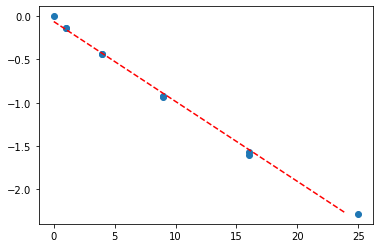

In [515]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,10)

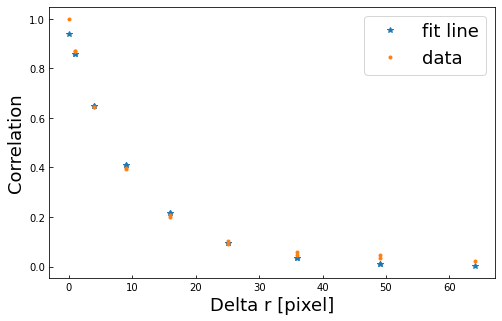

In [516]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [517]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :3.2899980919877385 pixel
The size is :0.27262391070424336 um


## 100 nm 0.27 wt% 20xobj 2.95 A.U.

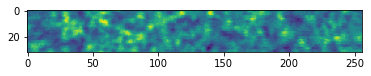

In [520]:
imgname='0p27percentwt_100nm_inglycerol_75umdepth_1min_2p95au_20xobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

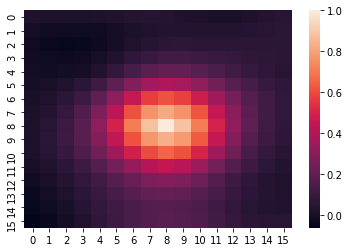

In [521]:
ROI=[7,10,17,230] #y,x,h,w
sp_shape=16
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 3.566349172813938
y = -0.07862 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


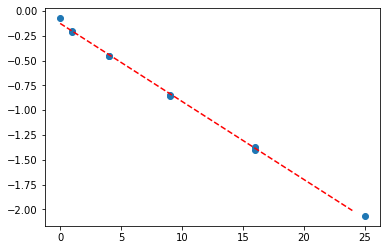

In [527]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,10)

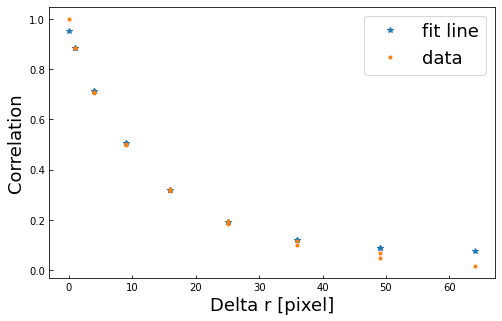

In [528]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [529]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :3.566349172813938 pixel
The size is :0.2955235934018295 um


## 100 nm 0.27 wt% 40xobj 1 A.U.

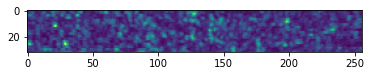

In [530]:
imgname='0p27percentwt_100nm_inglycerol_102umdepth_30s_1au_40xwobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

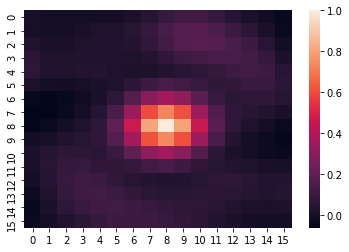

In [531]:
ROI=[7,10,17,230] #y,x,h,w
sp_shape=16
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 2.599660645063906
y = -0.14797 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


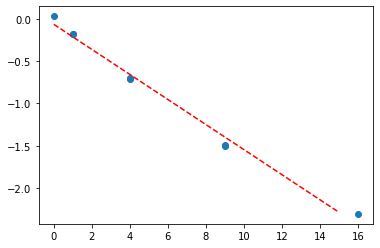

In [535]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,8)

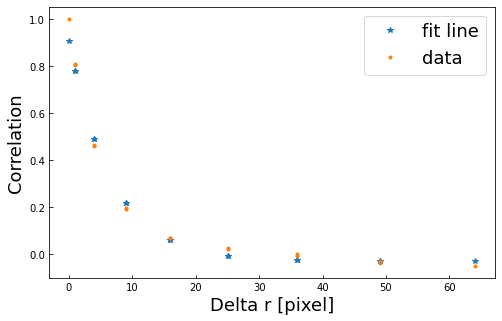

In [536]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [537]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.599660645063906 pixel
The size is :0.21541947191010083 um


## 100 nm 0.27 wt% 40xobj 4.08 A.U.

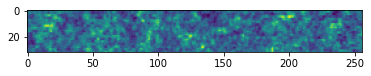

In [538]:
imgname='0p27percentwt_100nm_inglycerol_102umdepth_30s_4p08au_40xwobj'
foldername='/Volumes/WENYUN WANG/20220712/analysis/'
img=read_in_data(foldername,imgname)
img=img[300]

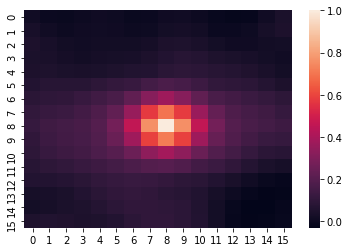

In [539]:
ROI=[7,10,17,230] #y,x,h,w
sp_shape=16
spmap=spatial_correlation(img,sp_shape,ROI)

speckle size is: 2.222468600053892
y = -0.20246 * x


<ipython-input-386-2fceac477bb8>:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


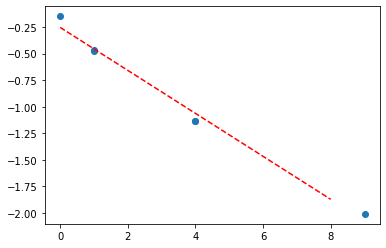

In [544]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,6)

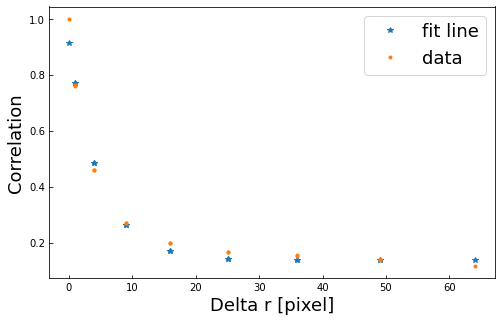

In [545]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [546]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.222468600053892 pixel
The size is :0.18416365731021073 um
